In [1]:
%pip install opendatasets
# %pip install panda
# %pip install tensorflow
# %pip install keras

import opendatasets as od
import pandas

In [2]:
import tensorflow as tf
from keras import *
import numpy as np
import seaborn as sns
import cv2
from sklearn.metrics import *
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
od.download("https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria/download?datasetVersionNumber=1")

Skipping, found downloaded files in "./cell-images-for-detecting-malaria" (use force=True to force download)


In [4]:
import tensorflow as tf
from keras import *
import numpy as np
import seaborn as sns
import cv2
from sklearn.metrics import *
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tqdm import tqdm
import matplotlib.pyplot as plt

In [5]:
def get_image(path, img_size ):
    img = np.array(tf.keras.utils.load_img(
        path,
        color_mode='rgb',
        target_size = img_size,
        interpolation ='nearest',
        keep_aspect_ratio = False
    ))
    return img

In [6]:
folder_path1 = r"/content/cell-images-for-detecting-malaria/cell_images/Parasitized"
folder_path2 = r"/content/cell-images-for-detecting-malaria/cell_images/Uninfected"
def load_images(folder_path, img_size):
    images_names = os.listdir(folder_path)
    X = np.zeros((7000, *img_size))
    for i, img_name in enumerate(images_names ):
        if i > 6999:
          break
        try:

            img_path = os.path.join(folder_path, img_name)
            img_array = get_image(img_path, img_size)
            X[i] = img_array
        except:
            X[i] = X[i - 1]
    return X / 255.0

cls1 = load_images(folder_path1, (75, 75, 3))
cls2 = load_images(folder_path2, (75, 75, 3))
cls1.shape, cls2.shape



((7000, 75, 75, 3), (7000, 75, 75, 3))

In [7]:
def show_images(images, labels):
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(images[i])
        plt.title(int(labels[i]))
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

In [8]:
label1 = np.ones(len(cls1),)
label2 = np.zeros(len(cls2),)
label1.shape, label2.shape

((7000,), (7000,))

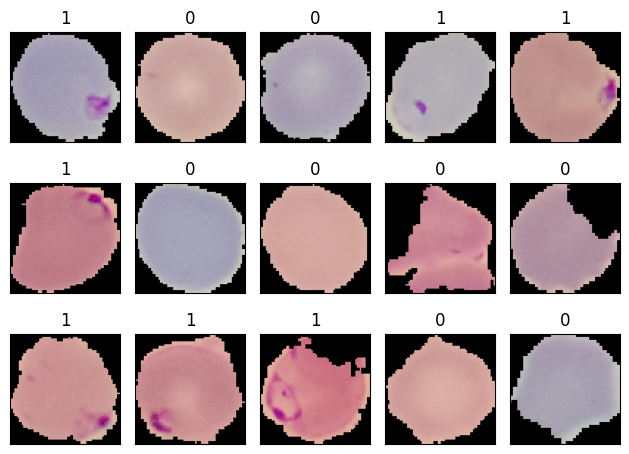

((9520, 75, 75, 3),
 (2800, 75, 75, 3),
 (1680, 75, 75, 3),
 (9520,),
 (2800,),
 (1680,))

In [9]:
X = np.concatenate([cls1, cls2], axis = 0)
y = np.concatenate([label1, label2], axis = 0)

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=1)

show_images(X_val, y_val)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape , y_val.shape

In [10]:
inception = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape = (75, 75, 3),
    input_tensor=None,
    pooling=None,
    classes=2,
    classifier_activation='sigmoid'
)

for layer in inception.layers:
    if layer.name.startswith('conv1') or layer.name.startswith('conv2'):
        layer.trainable = False

In [30]:
model = Sequential([
    inception,

    layers.GlobalAveragePooling2D(),

    layers.Flatten(),

    layers.Dense(32, activation = 'relu'),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(64, activation = 'relu', kernel_regularizer="l2"),

    layers.Dropout(0.7),

    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.5),

    layers.Dense(1, activation = 'sigmoid')
])

In [31]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.000058), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [32]:
validation_steps=20
initial_epochs = 20

validation_batches = (X_val, y_val)
loss0,accuracy0 = model.evaluate(X_val, y_val, steps = validation_steps)

20/20 [==============================] - 3s 27ms/step - loss: 1.5486 - accuracy: 0.5298


In [33]:
history2 = model.fit(X_train, y_train, epochs = initial_epochs , validation_data=validation_batches)


Epoch 1/20
298/298 [==============================] - 34s 51ms/step - loss: 1.4555 - accuracy: 0.5558 - val_loss: 1.3472 - val_accuracy: 0.8173
Epoch 2/20
298/298 [==============================] - 14s 46ms/step - loss: 1.1983 - accuracy: 0.7317 - val_loss: 1.0002 - val_accuracy: 0.8720
Epoch 3/20
298/298 [==============================] - 13s 44ms/step - loss: 0.9258 - accuracy: 0.8486 - val_loss: 0.8280 - val_accuracy: 0.8994
Epoch 4/20
298/298 [==============================] - 13s 44ms/step - loss: 0.7859 - accuracy: 0.8682 - val_loss: 0.7357 - val_accuracy: 0.8958
Epoch 5/20
298/298 [==============================] - 14s 46ms/step - loss: 0.6803 - accuracy: 0.8900 - val_loss: 0.6447 - val_accuracy: 0.9036
Epoch 6/20
298/298 [==============================] - 13s 45ms/step - loss: 0.6154 - accuracy: 0.8925 - val_loss: 0.5930 - val_accuracy: 0.9048
Epoch 7/20
298/298 [==============================] - 13s 44ms/step - loss: 0.5512 - accuracy: 0.9043 - val_loss: 0.5392 - val_accuracy:

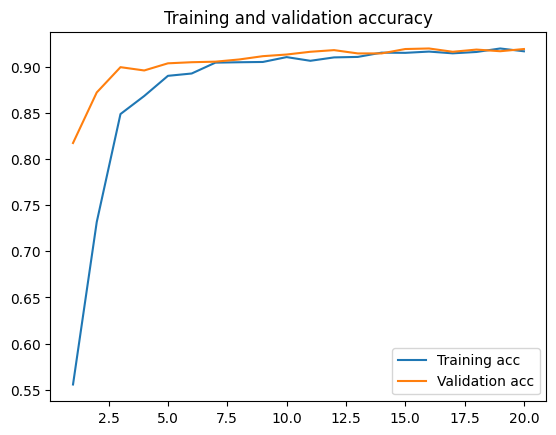

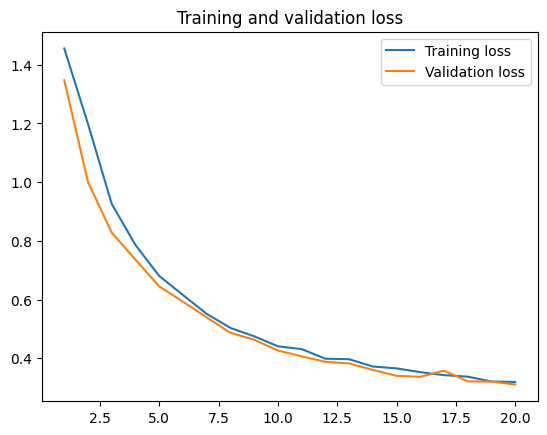

In [34]:

import matplotlib.pyplot as plt

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

88/88 [==============================] - 2s 13ms/step
Confusion matrix:
F1 score: 0.9053318824809576
Precision score: 0.9271916790490342
Accuracy score: 0.9067857142857143


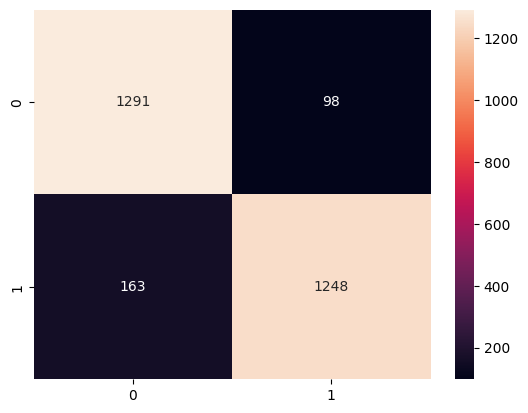

In [35]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, accuracy_score

y_pred = model.predict(X_test)

y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]

cm = confusion_matrix(y_test, y_pred_binary)

f1 = f1_score(y_test, y_pred_binary)

precision = precision_score(y_test, y_pred_binary)

accuracy = accuracy_score(y_test, y_pred_binary)

print("Confusion matrix:")
print("F1 score:", f1)
print("Precision score:", precision)
print("Accuracy score:", accuracy)
sns.heatmap(cm, annot = True, fmt = '.0f')
plt.show()

In [36]:
model.save("/content/cell-images-for-detecting-malaria/inception_v3.h5",save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
